In [ ]:
+
from google.colab import files
uploaded = files.upload()

Saving messy_hospital_patient_records.csv to messy_hospital_patient_records.csv


In [ ]:
import numpy as np
import sqlite3
import  pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
conn =sqlite3.connect('healthcare_audit.db')

In [ ]:
df_raw =pd.read_csv('/content/messy_hospital_patient_records.csv')

In [ ]:
df_raw.to_sql('raw_records',conn,index= False,if_exists=('replace'))

3000

In [ ]:
print("environment ready:raw record into SQL table'raw_records',")

environment ready:raw record into SQL table'raw_records',


In [ ]:
validation_sql = """
DROP TABLE IF EXISTS audiated_records;
CREATE TABLE  audiated_records AS
SELECT
*,
CASE
    WHEN  case_id  IS NULL THEN 'INVALID'
    WHEN  hospital IS NULL OR city IS NULL  OR department IS NULL THEN 'INVALID'
    WHEN  admission_date > discharge_date THEN 'INVALID'
    WHEN length_of_stay_days<=0 THEN 'INVALID'
    WHEN treatment_cost< 0 OR treatment_cost>500000 THEN 'INVALID'
    WHEN  insurance_covered_pct < 0 OR insurance_covered_pct >100 THEN 'INVALID'
    WHEN (outcome_status= 'expired' AND length_of_stay_days>60) THEN 'SUSPECIOUS'
    ELSE 'VALID'
END AS validation_status,

CASE
    WHEN case_id IS NULL THEN 'ERR_MISSING_ID'
    WHEN hospital IS NULL OR CITY IS NULL OR department IS NULL THEN 'ERR_MISSING_MAPPING'
    WHEN admission_date >discharge_date THEN 'ERR_DATE_LOGIC'
    WHEN length_of_stay_days<=0 THEN 'ERR_DATE_LOGIC'
    WHEN treatment_cost < 0 THEN 'ERR_NEG_COST'
    WHEN treatment_cost >500000 THEN 'ERR_HIGH_COST'
    WHEN insurance_covered_pct < 0  OR insurance_covered_pct >100 THEN 'ERR_INSURANCE_RANGE'
    ELSE 'CLEAN'
END AS reason_code
FROM raw_records;

DROP TABLE IF EXISTS valid_operational_records;
CREATE TABLE valid_operational_records AS
SELECT *
FROM audiated_records
WHERE validation_status='VALID';

DROP TABLE IF EXISTS invalid_records;
CREATE TABLE invalid_records AS
SELECT *
FROM audiated_records;
"""
conn.executescript(validation_sql)
print("valid and invalid records are seprated and stored")

valid and invalid records are seprated and stored


In [ ]:
risk_score_sql = """
 DROP TABLE IF EXISTS patient_risk_score;
 CREATE TABLE patient_risk_score AS
 SELECT
case_id,
hospital,
department,
city,
validation_status,
treatment_cost,
length_of_stay_days,

CAST(
  (CASE WHEN treatment_cost > 10000 THEN 30 ELSE 0 END) +
  (CASE WHEN outcome_status = 'expired' THEN 30 ELSE 0 END) +
  (CASE when insurance_covered_pct <20 THEN 20 ELSE 0 END) +
  (CASE WHEN validation_status =  'SUSPECIOUS' THEN 20 ELSE 0 END)

AS INT
)
 AS risk_score
FROM audiated_records;
"""

conn.executescript(risk_score_sql)
print("risk scoring complete")

risk scoring complete


In [ ]:
from ipython_genutils.py3compat import annotate
dept_audit = pd.read_sql("""
SELECT hospital, department,COUNT(*) AS total_cases,
SUM(CASE WHEN validation_status != 'VALID' THEN 1 ELSE 0 END ) * 100.0 / COUNT(*) as  error_rate_pct

FROM audiated_records
GROUP BY 1 ,2
HAVING total_cases >5
ORDER BY error_rate_pct DESC
LIMIT 10
""" , conn)

annotate= pd.read_sql("""
SELECT case_id, hospital,department,treatment_cost,risk_score
FROM patient_risk_score
WHERE risk_score< 10 AND  treatment_cost >200000 LIMIT 10
""",conn)

print("departments with highest reporting failtures")
print(dept_audit)
print("\n finantitial automalies(low risk extrime cost)")
print(annotate)

departments with highest reporting failtures
     hospital   department  total_cases  error_rate_pct
0        None         None          129      100.000000
1        None   Cardiology          101      100.000000
2        None    Emergency          126      100.000000
3        None          ICU          137      100.000000
4        None          OPD          122      100.000000
5        None  Orthopedics          136      100.000000
6  Hospital_X         None          123      100.000000
7  Hospital_Y         None          128      100.000000
8  Hospital_Z         None          127      100.000000
9  Hospital_X  Orthopedics          116       97.413793

 finantitial automalies(low risk extrime cost)
Empty DataFrame
Columns: [case_id, hospital, department, treatment_cost, risk_score]
Index: []


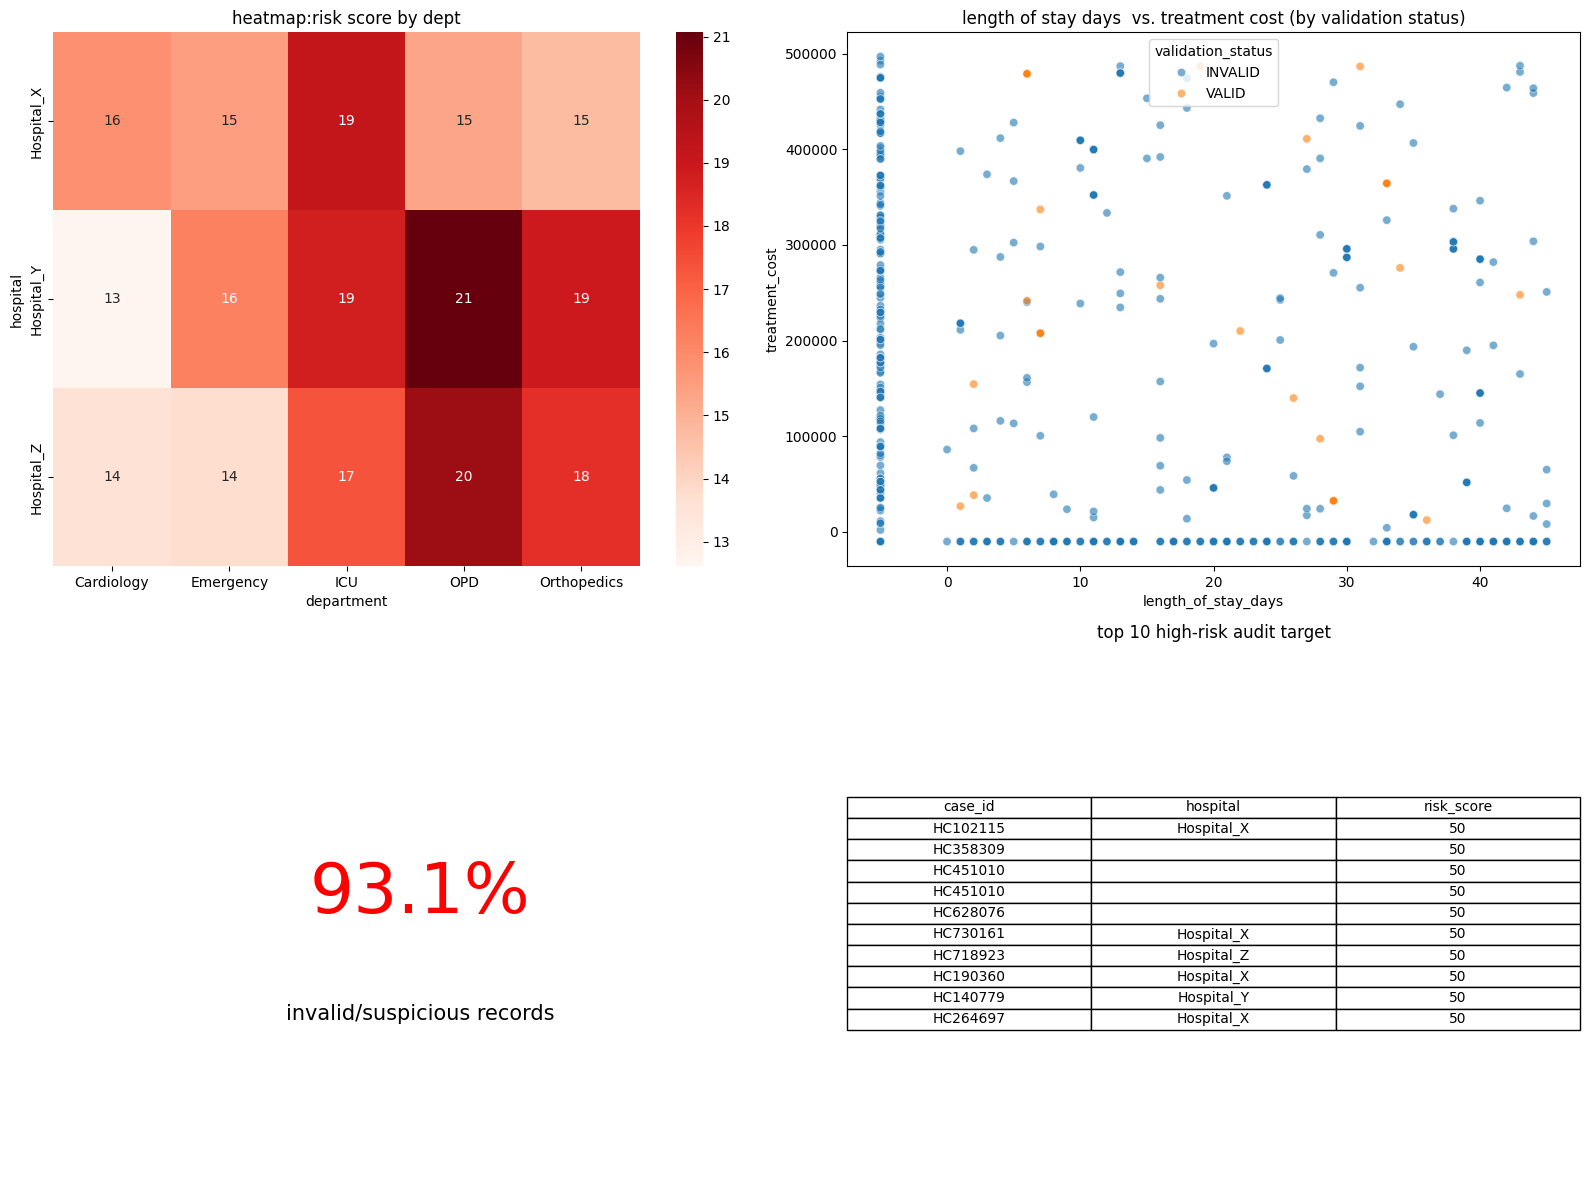

In [ ]:
viz_data= pd.read_sql("""
SELECT
  prs.case_id,
  prs.hospital,
  prs.department,
  prs.city,
  prs.validation_status,
  prs.treatment_cost,
  prs.length_of_stay_days,
  prs.risk_score,
  ar.admission_date,
  ar.discharge_date,
  ar.insurance_covered_pct,
  ar.outcome_status,
  ar.reason_code
FROM patient_risk_score AS prs
JOIN audiated_records AS ar
ON prs.case_id = ar.case_id
""",conn)

fig, axes= plt.subplots(2,2,figsize=(16,12))

pivot = viz_data.pivot_table(index='hospital',columns ='department',values='risk_score',aggfunc='mean')

sns.heatmap(pivot ,annot=True ,cmap='Reds',ax=axes[0,0])

axes[0,0].set_title("heatmap:risk score by dept")

sns .scatterplot(data=viz_data,x='length_of_stay_days', y='treatment_cost',hue ='validation_status',alpha=0.6,ax=axes[0,1])

axes[0,1].set_title("length of stay days  vs. treatment cost (by validation status)")

invalid_pct = (len(viz_data[viz_data['validation_status'] != 'VALID']) / len(viz_data)) * 100
axes[1,0].text(0.5,0.5 , f"{invalid_pct:.1f}%", fontsize=50,ha='center',color='red')
axes[1,0].text(0.5,0.3, "invalid/suspicious records",fontsize=15, ha='center')
axes[1,0].axis('off')

top_risk = viz_data.sort_values('risk_score', ascending=False)[['case_id','hospital','risk_score']].head(10)
axes[1,1].axis('tight')
axes[1,1].axis('off')
axes[1,1].table(cellText=top_risk.values,
                                     colLabels = top_risk.columns,
                                     loc='center', cellLoc='center')
axes[1,1].set_title("top 10 high-risk audit target")
plt.tight_layout()
plt.show()